In [259]:
%matplotlib notebook
from importlib import reload
import numpy as np
from tqdm import tnrange
import time
from scipy.stats import multivariate_normal as mvn
import copy
import matplotlib.pyplot as plt
from math import atan2, log, ceil
import os
from scipy.io import savemat

In [260]:
from IPython.core.debugger import set_trace

import numpy as np
from math import atan2
import random
from matplotlib import collections as mc

class Roadmap:
    """A class to represent a road network"""

    def __init__(self, nodes, edges, rotate=True, bidirectional=True):
        """
        nodes: list of tuples (x, y). Defines the cartesian location of each intersection.
        edges: list of tuples (start, end). Defines the roads between intersections. Each edge is
            unidirectional.
        """
        if rotate:
            first = 1
            second = 0
        else:
            first = 0
            second = 1
        #
        self.graph = {(node[first],node[second]) : {} for node in nodes}
        for edge in edges:
            a = (nodes[edge[0]][first],nodes[edge[0]][second])
            b = (nodes[edge[1]][first],nodes[edge[1]][second])
            slope = [b[0] - a[0], b[1] - a[1]]
            dist = np.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)
            self.graph[a][b] = dist

            if bidirectional:
                self.graph[b][a] = dist
            #
        #
        self._total_len = 0.0
        for dests in self.graph.values():
            self._total_len += np.sum(list(dests.values()))
        #

        # ==============================
        # ==============================

        self.nodes_sorted = sorted(self.graph.keys())
        new_ids = []
        edge_sort_tup = []
        self.edges_sorted = []
        for ii in nodes:
            new_ids.append(self.nodes_sorted.index(ii))
        #
        # # # --> new_ids = [0, 2, 4, 1, 3, 5]
        # set_trace()
        for ii in range(len(edges)):
            for jj in range(len(edges[ii])):
                edge_sort_tup.append( new_ids[edges[ii][jj]] )
            #
            next_edge = tuple(edge_sort_tup)
            self.edges_sorted.append(next_edge)
            edge_sort_tup = []
        #
        # set_trace()
        node_ids, neighbor_counts = np.unique( self.edges_sorted, return_counts=True )

        # node_ids, neighbor_counts = np.unique( np.asarray(edges), return_counts=True )
        self.max_neighbors = np.max( neighbor_counts )
        self.select_act = np.full( (len(node_ids),self.max_neighbors), np.nan )

        edg = np.array( self.edges_sorted ) #.astype(int)

        max_neighbor_idx = np.arange(self.max_neighbors)
        mix_locs = max_neighbor_idx

        for ii in node_ids:
            rows = np.where( edg == ii )[0]
            ii_mat = np.unique( edg[rows,:] )
            idx_ii = np.nonzero( ii_mat != ii )
            ell = ii_mat[idx_ii]

            # mix_locs = np.random.shuffle(max_neighbor_idx)
            np.random.shuffle(mix_locs)

            for its, jj in enumerate(ell):
                self.select_act[ii,mix_locs[its]] = jj
            #
        #
        # self.select_act.astype(int)
        # set_trace()
        # set_trace()
        # print(actions)
        # for key,value in self.graph.items():
        #     actions = max(actions, len(value))
    #
    def get_nearest_waypoint(self, pos):
        waypoint = None
        min_dist = 999999999
        for node in self.graph:
            dist = (pos[0] - node[0])**2 + (pos[1] - node[1])**2
            if dist < min_dist:
                min_dist = dist
                waypoint = node
            #
        #
        return waypoint
    #
    def get_next_waypoint(self, waypoint, psi):
        options = self.graph[waypoint].keys()
        next_wp = random.choice(options)
        next_psi = atan2(next_wp[0] - waypoint[0], next_wp[1] - waypoint[1])
        diff_angle = abs(((next_psi - psi) + np.pi) % (2*np.pi) - np.pi)
        return next_wp
    #
    def get_loc(self, state):
        """Returns the (x,y) location of a position along an edge

        edge -- tuple containing the (x,y) coordnates of
                the beginning and ending nodes of the edge
        pos  -- value between 0 and 1 indicating the distance along the edge
        """

        edge = state[0]
        pos = state[1]

        try:
            self.graph[edge[0]][edge[1]]
        except KeyError:
            raise ValueError("Invalid roadmap edge.")
        #
        loc = (pos*edge[1][0] + (1-pos)*edge[0][0],
               pos*edge[1][1] + (1-pos)*edge[0][1])
        return loc
    #
    def get_edge_weight(self, waypoint_a, waypoint_b):
        #TODO add in particle density to weight
        #   (more particles should decrease the weight making it more likely)
        return np.linalg.norm(np.array(waypoint_b) - np.array(waypoint_a))
    #
    def get_new_destination(self, current):
        options = self.graph.keys()
        options.remove(current[:2])
        next = random.choice(options)
        return (next[0], next[1], -100)
    #
    def get_lurd( self, node ):

        neighbors = self.graph[node]

        return lurd
    #
    def djikstra(self, waypoint, destination):
        visited = {waypoint[:2]: 0}
        path = {}
        nodes = set(self.graph.keys())
        while nodes:
            min_node = None
            for node in nodes:
                if node in visited.keys():
                    if min_node is None:
                        min_node = node
                    elif visited[node] < visited[min_node]:
                        min_node = node
                    #
                #
            #
            if min_node is None:
                break
            #
            nodes.remove(min_node)
            current_weight = visited[min_node]

            for edge in self.graph[min_node]:
                weight = current_weight + self.getEdgeWeight(min_node, edge)
                if edge not in visited or weight < visited[edge]:
                    visited[edge] = weight
                    path[edge] = min_node
                #
            #
        #
        shortest_path = [path[destination[0:2]], destination[0:2]]
        while shortest_path[0] != waypoint[:2]:
            shortest_path.insert(0,path[shortest_path[0]])
        #
        return shortest_path
    #
    @property
    def total_length(self):
        return self._total_len
    #
    def get_action_dimensions(self):
        # actions =  len(self.graph.keys())
        actions =  self.max_neighbors
        # print(actions)
        # for key,value in self.graph.items():
        #     actions = max(actions, len(value))
        return actions
    #
    # def visualize(self, ax):
    #     edges = []
    #     for a in self.graph:
    #         edges += [(a, b) for b in self.graph[a]]
    #     lc = mc.LineCollection(edges, colors=[(0,0,0,1)])
    #     ax.add_collection(lc)
    #
    def visualize(self, ax):
        edges = []
        for a in self.graph:
            edges += [(a, b) for b in self.graph[a]]
        #
        lc = mc.LineCollection(edges, colors=[(0,0,0,1)])
        ax.add_collection(lc)
    #
#

In [261]:
def getTriangle(side0, side1, angle2):
    side2 = np.sqrt(side0**2+side1**2-2*side0*side1*np.cos(angle2))
    # print(np.sin(angle2)*side0/side2, side0, side2)
    angle0 =  np.arccos((side1**2+side2**2-side0**2)/(2*side1*side2))
    return side2, angle0

def getRoundTripEst(n, side):
    if n == 2:
        return n*side
    if n < 2:
        return -1
    sides_from_vertex = [side]
    num_diagonals = int(2*n*(n-3)/2/n)
    side0 = side
    side1 = side
    corner_angle = (n-2)*np.pi/n
    # print(corner_angle*180/np.pi)
    angle2 = corner_angle
    for idx in range(num_diagonals):
        side2, angle0 = getTriangle(side0, side1, angle2)
        angle1 = np.pi-angle2-angle0
        sides_from_vertex.append(side*np.sin(angle1)/np.sin(angle2))
        side0 = side2
        side1 = side
        angle2 = corner_angle - angle0
    sides_from_vertex.append(side)
    # print(sides_from_vertex)
    # print('avg', np.mean(sides_from_vertex))
    return n*np.mean(sides_from_vertex)

In [262]:
def get_time(t, ts, offset, initial_range):
    time = t - (ts + offset)
    time[np.where(time<0)] = 0
    time[np.where(time>initial_range)] = initial_range
    return time

def getModeBirthDeathProb(t, ts, offsets, initial_range):
    probs = get_time(t, ts, 0, initial_range)
    for idx in range(len(offsets)):
        probs -= (1/len(offsets))*get_time(t, ts, offsets[idx], initial_range)
    probs /= initial_range
    return probs

def get_layer(key, initial_prob, initial_range, prob, ts, map_dict, t):
    test_data = {}
    prob_data = {}
    probs = map_dict[key]['prob']
    base_offsets = map_dict[key]['offsets']
    options = map_dict[key]['options']
    sum_probs = 0
    for idx in range(len(options)):
        next_key = prob * len(map_dict[options[idx]]['options'])
        if next_key not in test_data:
            test_data[next_key] = []
            prob_data[next_key] = np.zeros(len(t))
        if key is 'base':
            initial_prob = map_dict[options[idx]]['prob']
            initial_range = map_dict[options[idx]]['range']
        test_data[next_key].append([initial_prob,initial_range,ts+base_offsets[idx],options[idx]])

        offsets = map_dict[options[idx]]['offsets']
        sum_probs += initial_prob
        prob_data[next_key] += initial_prob*(1/prob)*getModeBirthDeathProb(t,ts+base_offsets[idx],offsets,initial_range)
    return test_data, prob_data

def get_recursive_layers(keys, data, prob_data, t, map_dict):
    next_keys_list = []
    new_modes = False
    for key in keys:
        for idx in data[key]:
            layer_key = idx[3]
            initial_prob = idx[0]
            initial_range = idx[1]
            prob = key
            ts = idx[2]
            if ts < t[-1]:
                new_modes = True
                tmp_data, tmp_prob_data = get_layer(layer_key, initial_prob, initial_range, prob, ts, map_dict, t)
                for tmp_key in tmp_data.keys():
                    if tmp_key not in data:
                        data[tmp_key] = []
                        prob_data[tmp_key] = np.zeros(len(t))
                        next_keys_list.append(tmp_key)
                    data[tmp_key].extend(tmp_data[tmp_key])
                    prob_data[tmp_key] += tmp_prob_data[tmp_key]
    if new_modes:
        get_recursive_layers(next_keys_list, data, prob_data, t, map_dict)

def getModeProbabilities(map_dict, dt, max_duration):
    t = np.array([idx*dt for idx in range(int(max_duration/dt))])
    test_data, prob_data = get_layer('base',0,0,1,0,map_dict,t)
    get_recursive_layers(list(test_data.keys()), test_data, prob_data, t, map_dict)
    prob_data_1 = np.ones(len(t))
    keys = list(prob_data)
    if 1 in keys:
        keys.remove(1)
    for key in keys:
        prob_data_1 -= prob_data[key]
        # print(key,prob_data_1[50])
    prob_data[1] = prob_data_1
    # for idx in range(len(map_dict['base']['prob'])):
        # ranges = map_dict['base']['range']
        # base_probs = map_dict['base']['prob']
        # offsets = map_dict['base']['offsets']
        # options = map_dict['base']['options']
        # prob_data[1] -= base_probs[idx]*(1./ranges[idx])*get_time(t,0,offsets[idx],ranges[idx])
    return t, test_data, prob_data

In [272]:
def createGridLayout(x,y,min_edge_length, max_edge_length):
    nodes = []
    edges = []
    for i in range(y):
        for j in range(x):
            x_val = 0
            y_val = 0
            if i > 0:
                y_val = nodes[(i-1)*x + j][1]+ np.random.uniform(low=min_edge_length, high=max_edge_length)
            if j > 0:
                x_val = nodes[i*x+j-1][0]+ np.random.uniform(low=min_edge_length, high=max_edge_length)
            nodes.append((
                x_val,
                y_val ))

    for i in range(y):
        for j in range(x-1):
            edges.append((j+x*i,j+1+x*i))
    
    for i in range(y-1):
        for j in range(x):
            edges.append((j+x*i,j+x*(i+1)))
    return [nodes, edges]

def DjikstraGraph(graph, initial_node):
    nodes = sorted(graph.keys())
    unvisited = sorted(graph.keys())
    visited = []
    dists = []
    paths = []
    for node in nodes:
        dists.append(np.inf)
        paths.append([])
        if node == initial_node:
            dists[-1] = 0
    while len(visited) < len(nodes):
        best_node = None
        best_node_val = -1
        for node in unvisited:
            if dists[nodes.index(node)] < best_node_val or best_node is None:
                best_node_val = dists[nodes.index(node)]
                best_node = node
        start_node = best_node
        visited.append(start_node)
        unvisited.remove(start_node)
        index_start = nodes.index(start_node)
        for node in graph[start_node].keys():
            index = nodes.index(node)
            new_dist = dists[index_start] + graph[start_node][node]
            if new_dist < dists[index]:
                dists[index] = new_dist
                paths[index] = paths[index_start]
                paths[index].append(node)
    return dists

def getAvgDistance(r):
    vals = []
    for node in sorted(r.graph.keys()):
        avg_dist = np.mean(DjikstraGraph(r.graph, node))
        vals.append(avg_dist)
    return np.mean(vals)

def getDuration(x,y, dist, Va, targets, agents):
    nodes, edges = createGridLayout(x,y,dist, dist)
    r = Roadmap(nodes, edges, rotate=False)
    edge_lengths = []
    for key in r.graph.keys():
        for key2 in r.graph[key].keys():
            edge_lengths.append(r.graph[key][key2])
    L_avg = 100.0
    num_edges = 12.0

#     avg_dist = getAvgDistance(r)
#     dur = getRoundTripEst(targets, avg_dist)/Va
#     print('avg', avg_dist)
    
    S_node = getAvgDistance(r)
    S_point = S_node*(1 + 1./num_edges) - L_avg*(1. + (2./(3.*num_edges)))
    S_point = 166
    dur = getRoundTripEst(targets, S_point)/Va
    print('s_node', S_node, 's_point', S_point, 'dur', dur)
    return dur;

def getMapDict3x3(dist, v0):
    edge_dur = dist/v0
    return {
        'base': {
            'offsets': [0,0,0],
            'options': [0,1,2],
            'range': [2*edge_dur, edge_dur, edge_dur],
            'prob': [4./6, 1./6, 1./6]
        },
        0: {'offsets': [2*edge_dur,edge_dur],
           'options': [0,1],
           'range': 2*edge_dur,
           'prob':4./6},#4/6
        1: {'offsets': [edge_dur, edge_dur, edge_dur],
           'options': [2,2,2],
           'range': edge_dur,
           'prob': 1./6},#1/6
        2: {'offsets': [2*edge_dur,2*edge_dur],
           'options': [0,0],
           'range': edge_dur,
           'prob': 1./6}#1/6
    }
def probabilityMode2Time(probabilities):
    probabilites_by_time = []
    for jdx in range(len(probabilities[1])):
        probabilites_by_time.append({})
        for key in probabilities.keys():
            probabilites_by_time[-1][key] = probabilities[key][jdx]
    return probabilites_by_time

def getInitialVariance(x,y,dist, Va, dt, sigma, R, targets, agents):
    dur = getDuration(x,y,dist, Va, targets, agents)
#     print((-(dur*dt**2*sigma**2)+np.sqrt((dur*dt**2*sigma**2)**2 + 4*R*dur*dt**2*sigma**2))/2, (-(dur*dt*sigma**2)+np.sqrt((dur*dt*sigma**2)**2 + 4*R*dur*dt*sigma**2))/2)
#     return (-(dur*dt*sigma**2)+np.sqrt((dur*dt*sigma**2)**2 + 4*R*dur*dt*sigma**2))/2
    return (-(dur*dt**2*sigma**2)+np.sqrt((dur*dt**2*sigma**2)**2 + 4*R*dur*dt**2*sigma**2))/2

def getEntropy(probability, mode_probability):
    entropy = 0
    for num_modes in mode_probability.keys():
        for idx in range(len(probability)):
            if np.isfinite(np.log((1/num_modes)*probability[idx])) and probability[idx] > 0:
                entropy += mode_probability[num_modes]*(-probability[idx]*np.log((1/num_modes)*probability[idx]))
    return entropy

def getProbAndEntropy(variance, x, mu, mode_probability,step_size):
    probability = 1./np.sqrt(2*np.pi*variance)*np.exp(-(x-mu)**2/(2*variance))
    cdf = []
    for idx in range(0,len(probability),step_size):
#         cdf_sum = 0
#         for jdx in range(idx, step_size):
#             cdf_sum += sum(probability[:jdx])
        cdf.append(sum(probability[:idx]))
#         cdf.append(cdf_sum)
#     print(cdf)
#     print(sum(probability))
#     cdf = norm.cdf(x=x,loc=mu, scale=variance)
#     print(cdf)
#     print(np.concatenate(([0], cdf[0:-1])))
    probability = cdf - np.concatenate(([0], cdf[0:-1]))
#     print(probability)
    entropy = getEntropy(probability, mode_probability)
    return probability, entropy

def fill_prediction(ent):
    for idx in range(1,len(ent)):
        if np.isnan(ent[idx]):
            for jdx in range(idx,len(ent)):
                if not np.isnan(ent[jdx]):
                    slope = (ent[jdx]- ent[idx-1])/(jdx-(idx-1))
                    for kdx in range(idx, jdx):
                        ent[kdx] = ent[idx-1] + slope*(kdx-(idx-1))
                    break

    return ent

def getProbAndEntropyOverTime(var_0, map_size, dt, sigma, num_steps, mode_probability, step_size=1, zero_out=False):
    mu = map_size/2.
    distance = np.array([idx for idx in range(0,int(map_size), 1)])
    prob_over_time = []
    entropy_over_time = []
    for idx in range(num_steps):
        var = var_0 + idx*(dt*sigma)**2
#         print(mode_probability[idx])
#         print(mode_probability)
        prob, entropy = getProbAndEntropy(var, distance, mu, mode_probability[idx], step_size)
        prob_over_time.append(prob)
        entropy_over_time.append(entropy)
    return prob_over_time, entropy_over_time

def getLowerBoundsForMap(dist, layout, dt, sigma, Va, R, targets, agents, probability_by_time):
#     data = np.load("data/data_2x3-{}-1_h_0.npy".format(dist))
#     v_data = np.load("data/data_2x3-{}-1_v_0.npy".format(dist))
#     plot_data = np.mean(data, axis=0)
#     t = np.array([idx*dt for idx in range(plot_data.shape[0])])

    avg_min_variance = getInitialVariance(layout[0],layout[1],dist,Va,dt,sigma,R,targets,agents)
#     print(avg_min_variance)

    num_edges = (layout[0]-1)*layout[1] + (layout[1]-1)*layout[0]
    map_size = num_edges*dist
    predicted_est_by_time, predicted_ent = getProbAndEntropyOverTime(avg_min_variance, int(map_size), dt,
                                                                     sigma, len(probability_by_time),
                                                                     probability_by_time, 1)
    fill_prediction(np.copy(predicted_ent))

#     lower_bound = np.mean(plot_data[750:])
    predicted_lower_bound = np.nanmean(predicted_ent)
    return predicted_lower_bound, avg_min_variance, predicted_ent

def getLowerBounds(dists, layout, dt, sigma, Va, R, targets,agents, probability_array):
    lower_bounds = []
    predicted_lower_bounds = []
    avg_min_variances = []
    entropy = []
    for idx in range(len(dists)):
        
        predicted_lower_bound, avg_min_variance, predicted_ent = getLowerBoundsForMap(dists[idx], layout,
                                                                       dt, sigma, Va, R, targets, agents,
                                                                       probability_array[idx])
#         lower_bounds.append(lower_bound)
        predicted_lower_bounds.append(predicted_lower_bound)
        avg_min_variances.append(avg_min_variance)
        entropy.append(predicted_ent)
    return predicted_lower_bounds, avg_min_variances, entropy

def getProbabilityByDistsByTime(dists, dt, Va, v0, dur=None):
    probability_array = []
    for idx in range(len(dists)):
        dur = getDuration(3,3, dists[idx], Va,2,1)
        map_dict3x3 = getMapDict3x3(dists[idx], v0)
        t, test_data, prob_data = getModeProbabilities(map_dict3x3, dt, dur)
        probability_array.append(probabilityMode2Time(prob_data))
    return probability_array


In [273]:
## dists = [50, 100, 150, 200, 250,300]
dists = [100]
v0 = 10
R=5
Va = 40
sigma = 4
dt = .1
targets = 2
agents = 1

lower_bounds_pred = []
min_var = []

probability_array = getProbabilityByDistsByTime(dists, dt, Va, v0)

predicted_lower_bounds, avg_min_variances, entropy = getLowerBounds(dists, (3,3), dt, sigma, Va, R, targets,
                                                                    agents, probability_array)
lower_bounds_pred.append(predicted_lower_bounds)
min_var.append(avg_min_variances)
print('Est bound', predicted_lower_bounds)

s_node 177.77777777777777 s_point 166 dur 8.3
s_node 177.77777777777777 s_point 166 dur 8.3


/home/mouse/.virtualenvs/deep/local/lib/python3.6/site-packages/ipykernel_launcher.py:124: RuntimeWarning: divide by zero encountered in log


Est bound [2.6461015341396825]


<IPython.core.display.Javascript object>


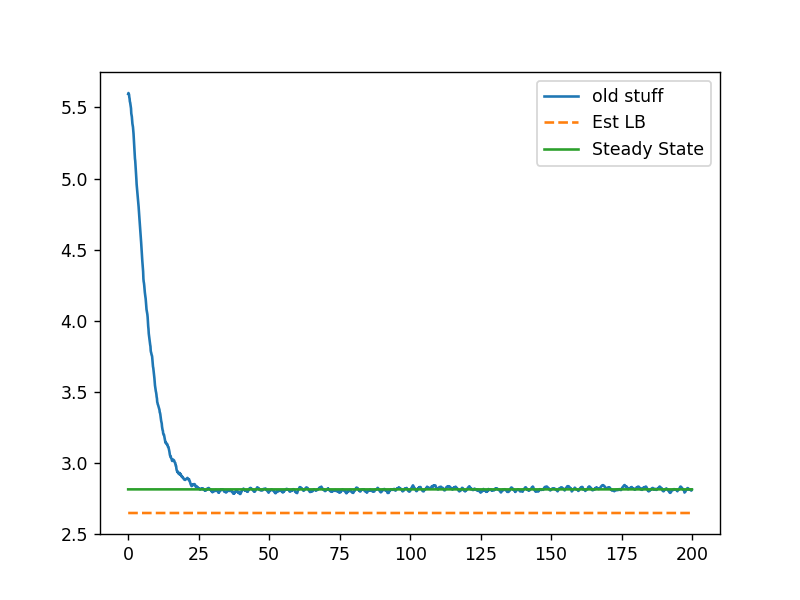

In [274]:
data = np.load("data_3x3-100-1_h_0.npy")
plot_data=np.mean(data,axis=0)
plot_data=np.mean(plot_data,axis=1)
t=[idx*dt for idx in range(plot_data.shape[0])]
plt.figure()
plt.plot(t, plot_data, label='old stuff')
plt.plot(t, [predicted_lower_bounds for jdx in range(len(t))], '--', label='Est LB')
plt.plot(t, [np.mean(plot_data[200:]) for jdx in range(len(t))], label='Steady State')
plt.legend()

(460, 1500, 2)


<IPython.core.display.Javascript object>


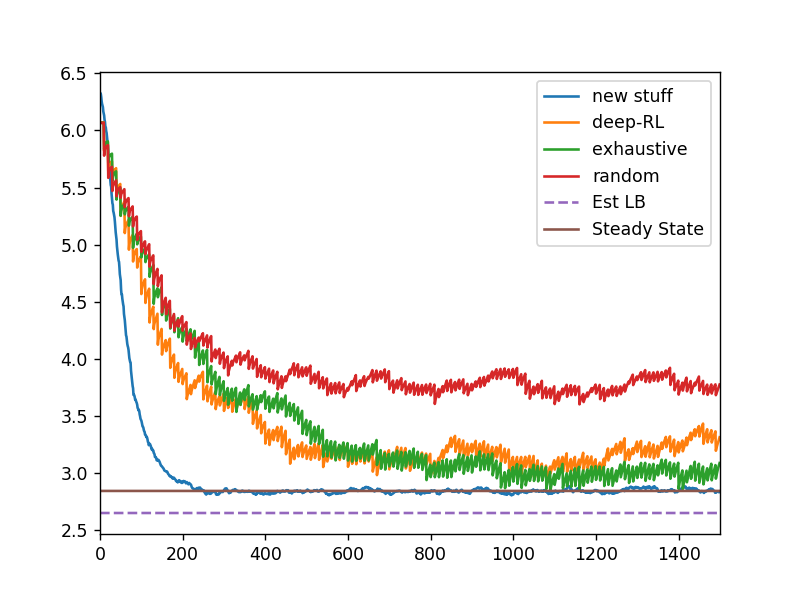

[2.6461015341396825] 2.8395837457589743


In [293]:
def processData(name, l=1500):
    tmp = np.load(name)
    data = []
    min_x = np.inf
    for line in tmp:
        if len(line) > l:
            data.append(line[:l])
    return np.mean(np.mean(np.array(data),axis=0),axis=1)

# data = np.load("ideal_h.npy")
files = ['ideal_h_A.npy', 'ideal_h_B.npy', 'ideal_h_C.npy',
        'ideal_h_D.npy', 'ideal_h_E.npy', 'ideal_h_F.npy',
        'ideal_h_G.npy', 'ideal_h_H.npy']
files = ['A','B','C','D','E','F','G','H', 'I','J','K','L', 'O',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
         'Y', 'Z']
data = [np.load('ideal_4.npy')[:,:1500,:]]
for file in files:
    try:
        data.append(np.load('temp/ideal_h_{}4.npy'.format(file))[:,:1500,:])
#         print(data[-1].shape)
    except:
        pass
data = np.vstack(data)
data = np.unique(data,axis=0)
np.save('ideal_4.npy', data)
print(data.shape)
plot_data=np.mean(data,axis=0)
plot_data=np.mean(plot_data,axis=1)
t=[idx*dt for idx in range(plot_data.shape[0])]
rl = processData('path_planner_data_rl.npy')
exh = processData('path_planner_data_exhaustive.npy')
rand = processData('path_planner_data_random.npy')
plt.figure()
plt.plot(plot_data, label='new stuff')
plt.plot(rl, label='deep-RL')
plt.plot(exh, label='exhaustive')
plt.plot(rand,label='random')
plt.plot([predicted_lower_bounds for jdx in range(len(t))], '--', label='Est LB')
steady_state = np.mean(plot_data[500:])
plt.plot([steady_state for jdx in range(len(t))], label='Steady State')
plt.legend()
plt.xlim([0,1500])
print(predicted_lower_bounds, steady_state)

In [297]:
# plt.figure()
# plt.plot(data[0,:,:])
count = 0
total_durs = 0
for jdx in range(data.shape[0]):
    mins = [[],[]]
    last = [data[jdx,0,0], data[jdx,0,1]]
    for idx in range(1,data.shape[1]):
        if data[jdx,idx,0] < last[0]-.3:
            mins[0].append([idx,data[jdx,idx,0]])
        last[0]=data[jdx,idx,0]
        if data[jdx,idx,1] < last[1]-.3:
            mins[1].append([idx,data[jdx,idx,1]])
        last[1] = data[jdx,idx,1]
    min0=np.array(mins[0])
    min1=np.array(mins[1])
#     plt.plot(min0[:,0], min0[:,1])
    total_durs += np.sum(np.diff(min0[:,0]))
    count += np.diff(min0[:,0]).shape[0]
print(count)
# print(np.mean(np.diff(min0[:,0])))
print(total_durs/count)

8938
72.40713806220631
